# Deepfake detection using GAN

In [55]:
# Imports
import numpy as np
import random
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from tqdm import tqdm

import matplotlib.animation as animation
from IPython.display import HTML

Controlling seeds to control reproducability.

In [56]:
if False:
    seed = 0
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [57]:
# Root directory for dataset
dataroot = "sample_set_faces/real"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

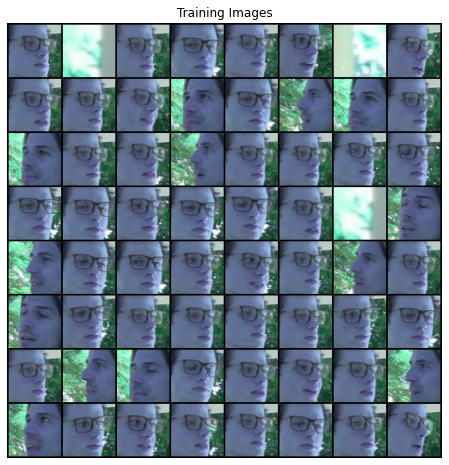

In [58]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = tv.datasets.ImageFolder(
    root=dataroot,
    transform=tv.transforms.Compose(
        [
            tv.transforms.Resize(image_size),
            tv.transforms.CenterCrop(image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)


datasetfake = tv.datasets.ImageFolder(
    root="sample_set_faces/fake",
    transform=tv.transforms.Compose(
        [
            tv.transforms.Resize(image_size),
            tv.transforms.CenterCrop(image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

dataloaderfake = torch.utils.data.DataLoader(
    datasetfake, batch_size=batch_size, shuffle=True, num_workers=workers
)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        tv.utils.make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)


In [59]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [60]:
class Discriminator(torch.nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = torch.nn.Sequential(
            # input is (nc) x 64 x 64
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [61]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = torch.nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [62]:
# Initialize BCELoss function
criterion = torch.nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [63]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    itfake = iter(dataloaderfake)
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        fake_cpu = next(itfake)[0].to(device)
        b_size = fake_cpu.size(0)
        label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        # Classify all fake batch with D
        output = netD(fake_cpu).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        # Output training stats
        if i % 50 == 0:
            print(f'[{epoch/num_epochs}][{i, len(dataloader)}]\tLoss_D: {round(errD.item()), 4}\tD(x): {round(D_x, 4)}\tD(G(z)): {D_G_z1}')

        # Save Losses for plotting later
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            img_list.append(tv.utils.make_grid(fake_cpu, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0.0][(1, 4)]	Loss_D: (0, 4)	D(x): 0.9433	D(G(z)): 0.10596977919340134
[0.0][(2, 4)]	Loss_D: (0, 4)	D(x): 0.9876	D(G(z)): 0.013535935431718826
[0.0][(3, 4)]	Loss_D: (0, 4)	D(x): 0.9971	D(G(z)): 0.00014225469203665853
[0.06666666666666667][(1, 4)]	Loss_D: (0, 4)	D(x): 0.9993	D(G(z)): 0.003222496947273612
[0.06666666666666667][(2, 4)]	Loss_D: (0, 4)	D(x): 0.9996	D(G(z)): 0.00015136106230784208
[0.06666666666666667][(3, 4)]	Loss_D: (0, 4)	D(x): 0.9977	D(G(z)): 0.00010315097460988909
[0.13333333333333333][(1, 4)]	Loss_D: (0, 4)	D(x): 0.9992	D(G(z)): 0.00020508076704572886
[0.13333333333333333][(2, 4)]	Loss_D: (0, 4)	D(x): 0.9993	D(G(z)): 6.207961268955842e-05
[0.13333333333333333][(3, 4)]	Loss_D: (0, 4)	D(x): 0.9998	D(G(z)): 5.999720815452747e-05
[0.2][(1, 4)]	Loss_D: (0, 4)	D(x): 0.9996	D(G(z)): 9.294395567849278e-05
[0.2][(2, 4)]	Loss_D: (0, 4)	D(x): 0.9998	D(G(z)): 9.009501809487119e-05
[0.2][(3, 4)]	Loss_D: (0, 4)	D(x): 0.9998	D(G(z)): 5.70090560358949e-05
[0.

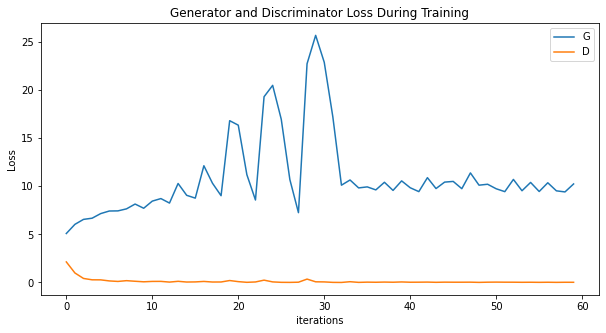

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


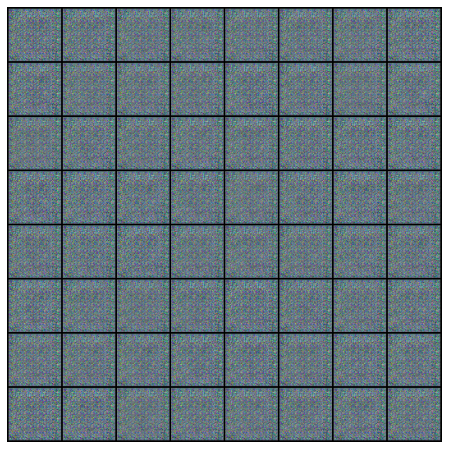

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())